In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Multiply, Permute, Flatten, RepeatVector, Softmax
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from sklearn.preprocessing import MinMaxScaler

In [23]:
data = pd.read_csv('./stock_data/BTC_2010-2011.csv')

# Chuyển đổi cột 'Date' sang datetime và đặt làm index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

print("Các cột trong dữ liệu:", data.columns)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

print("Các cột trong dữ liệu:", data.columns)

print(data.describe())
print("Số lượng giá trị NaN trong mỗi cột:")
print(data.isnull().sum())
print("Kiểm tra giá trị inf/-inf:")
print(data[data.isin([np.inf, -np.inf]).any(axis=1)])

# Loại bỏ các hàng có giá trị NaN hoặc inf
data = data.dropna()  # Xóa hàng chứa NaN
data = data.replace([np.inf, -np.inf], np.nan).dropna()  # Loại bỏ inf/-inf

# scaler = MinMaxScaler()
# scaled_data = scaler.fit_transform(data)

scaled_data = pd.DataFrame(scaled_data, columns=data.columns, index=data.index)
# scaled_data = pd.DataFrame(scaled_data, columns=data.columns, index=data.index)

# Số bước thời gian
timesteps = 100

X = []
y = []

close_index = data.columns.get_loc('Close')

for i in range(timesteps, len(scaled_data)):
    X.append(scaled_data.iloc[i - timesteps:i].values)
    y.append(scaled_data.iloc[i, close_index])

X = np.array(X)
y = np.array(y)

print("Shape of X:", X.shape)  # (samples, timesteps, features)
print("Shape of y:", y.shape)

Các cột trong dữ liệu: Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')
Các cột trong dữ liệu: Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')
          Adj Close         Close          High           Low          Open        Volume
count  34105.000000  34105.000000  34105.000000  34105.000000  34105.000000  3.410500e+04
mean   75734.798419  75734.798419  75734.798419  75734.798419  75734.798419  1.745148e+07
std     9053.527931   9053.527931   9053.527931   9053.527931   9053.527931  1.568273e+08
min    65198.042969  65198.042969  65198.042969  65198.042969  65198.042969  0.000000e+00
25%    68153.375000  68153.375000  68153.375000  68153.375000  68153.375000  0.000000e+00
50%    72066.203125  72066.203125  72066.203125  72066.203125  72066.203125  0.000000e+00
75%    86629.593750  86629.593750  86629.593750  86629.593750  86629.593750  1.240269e+07
max    93409.023438  93409.023438  93409.023438  93409.023438  93409.023438 

In [24]:
# # Số bước thời gian
# timesteps = 100
# 
# # Chuẩn hóa toàn bộ dữ liệu trước khi tạo X và y [0, 1]
# scaler = MinMaxScaler() 
# scaled_data = scaler.fit_transform(data)
# 
# X = []
# y = []
# 
# for i in range(timesteps, len(scaled_data)):
#     X.append(scaled_data[i-timesteps:i, :-1])
#     y.append(scaled_data[i, 1])
# 
# X = np.array(X)
# y = np.array(y)
# 
# print("Shape of X:", X.shape)  # (samples, timesteps, features)
# print("Shape of y:", y.shape)

Shape of X: (34005, 100, 5)
Shape of y: (34005,)


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train size:", X_train.shape, "Test size:", X_test.shape)

Train size: (27204, 100, 5) Test size: (6801, 100, 5)


In [26]:
def attention_block(inputs):
    attention = Dense(1, activation='tanh')(inputs)  # Học trọng số
    attention = Flatten()(attention)  # Đưa về dạng 1D
    attention = Softmax()(attention)  # Softmax layer
    attention = RepeatVector(K.int_shape(inputs)[2])(attention)  # Lặp lại trọng số theo chiều features
    attention = Permute([2, 1])(attention)  # Hoán vị để phù hợp với inputs
    weighted_inputs = Multiply()([inputs, attention])  # Nhân trọng số với inputs
    return weighted_inputs

# Xây dựng mô hình với Attention
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))

# LSTM Layer 1
lstm_out_1 = LSTM(128, activation='relu', return_sequences=True)(inputs)
lstm_out_1 = Dropout(0.1)(lstm_out_1)

# Attention Layer
attention_out = attention_block(lstm_out_1)

# LSTM Layer 2
lstm_out_2 = LSTM(64, activation='relu', return_sequences=False)(attention_out)
lstm_out_2 = Dropout(0.1)(lstm_out_2)

# Output Layer
output = Dense(1)(lstm_out_2)

model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])

print(model.summary())

model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 100, 5)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 100, 128)  │     68,608 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 100, 128)  │          0 │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 100, 1)    │        129 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 100)       │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax_1 (Softmax) │ (None, 100)       │          0 │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_1     │ (None, 128, 100)  │          0 │ softmax_1[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute_1 (Permute) │ (None, 100, 128)  │          0 │ repeat_vector_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 100, 128)  │          0 │ dropout_5[0][0],  │
│ (Multiply)          │                   │            │ permute_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 64)        │     49,408 │ multiply_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 64)        │          0 │ lstm_6[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1)         │         65 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 118,210 (461.76 KB)

 Trainable params: 118,210 (461.76 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 70s 100ms/step - loss: 0.3020 - mae: 0.3020 - val_loss: 0.2516 - val_mae: 0.2516
Epoch 2/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 63s 93ms/step - loss: 0.2193 - mae: 0.2193 - val_loss: 0.0302 - val_mae: 0.0302
Epoch 3/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 62s 91ms/step - loss: 0.0259 - mae: 0.0259 - val_loss: 0.0099 - val_mae: 0.0099
Epoch 4/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 66s 98ms/step - loss: 0.0224 - mae: 0.0224 - val_loss: 0.0196 - val_mae: 0.0196
Epoch 5/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 63s 92ms/step - loss: 0.0218 - mae: 0.0218 - val_loss: 0.0077 - val_mae: 0.0077
Epoch 6/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 60s 89ms/step - loss: 0.0200 - mae: 0.0200 - val_loss: 0.0110 - val_mae: 0.0110
Epoch 7/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 63s 93ms/step - loss: 0.0195 - mae: 0.0195 - val_loss: 0.0097 - val_mae: 0.0097
Epoch 8/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 63s 92ms/step - loss: 0.0191 - mae: 0.0191 - val_loss: 0.0078 - val_mae: 0.0078
Epoch 9/50
681/681 ━━━━━━━━━━━━━━━

In [27]:
y_pred = model.predict(X_test)

print("Shape of predictions:", y_pred.shape)

213/213 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step
Shape of predictions: (6801, 1)


In [28]:
# Chuyển đổi giá trị dự đoán và thực tế về thang đo gốc
y_pred_original = scaler.inverse_transform(np.concatenate((y_pred, np.zeros((y_pred.shape[0], data.shape[1] - 1))), axis=1))[:, 0]
y_test_original = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], data.shape[1] - 1))), axis=1))[:, 0]

In [32]:
mse_original = mean_squared_error(y_test_original, y_pred_original)
rmse_original = np.sqrt(mse_original)
mae_original = mean_absolute_error(y_test_original, y_pred_original)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f"MSE Original: {mse_original}")
print(f"RMSE Original: {rmse_original}")
print(f"MAE Original: {mae_original}")

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

MSE Original: 85147.55888952811
RMSE Original: 291.8005464174598
MAE Original: 234.6911438485474
MSE: 0.00010698819019525001
RMSE: 0.010343509568577292
MAE: 0.00831914169408341


                     Thời gian  Thực tế (Actual)  Dự đoán (Predicted)  Hiệu (Actual - Predicted)
0    2024-11-13 11:50:00+00:00      68261.335938         68530.805096                -269.469158
1    2024-11-13 11:51:00+00:00      72501.015625         72758.548930                -257.533305
2    2024-11-13 11:53:00+00:00      67413.671875         67451.948454                 -38.276579
3    2024-11-13 11:54:00+00:00      73598.343750         73633.390825                 -35.047075
4    2024-11-13 11:56:00+00:00      70705.359375         70822.486232                -117.126857
...                        ...               ...                  ...                        ...
6796 2024-11-19 17:16:00+00:00      87526.867188         87860.433727                -333.566539
6797 2024-11-19 17:17:00+00:00      67420.039062         67399.271302                  20.767761
6798 2024-11-19 17:18:00+00:00      88148.085938         88531.033241                -382.947304
6799 2024-11-19 17:19:00+00:00

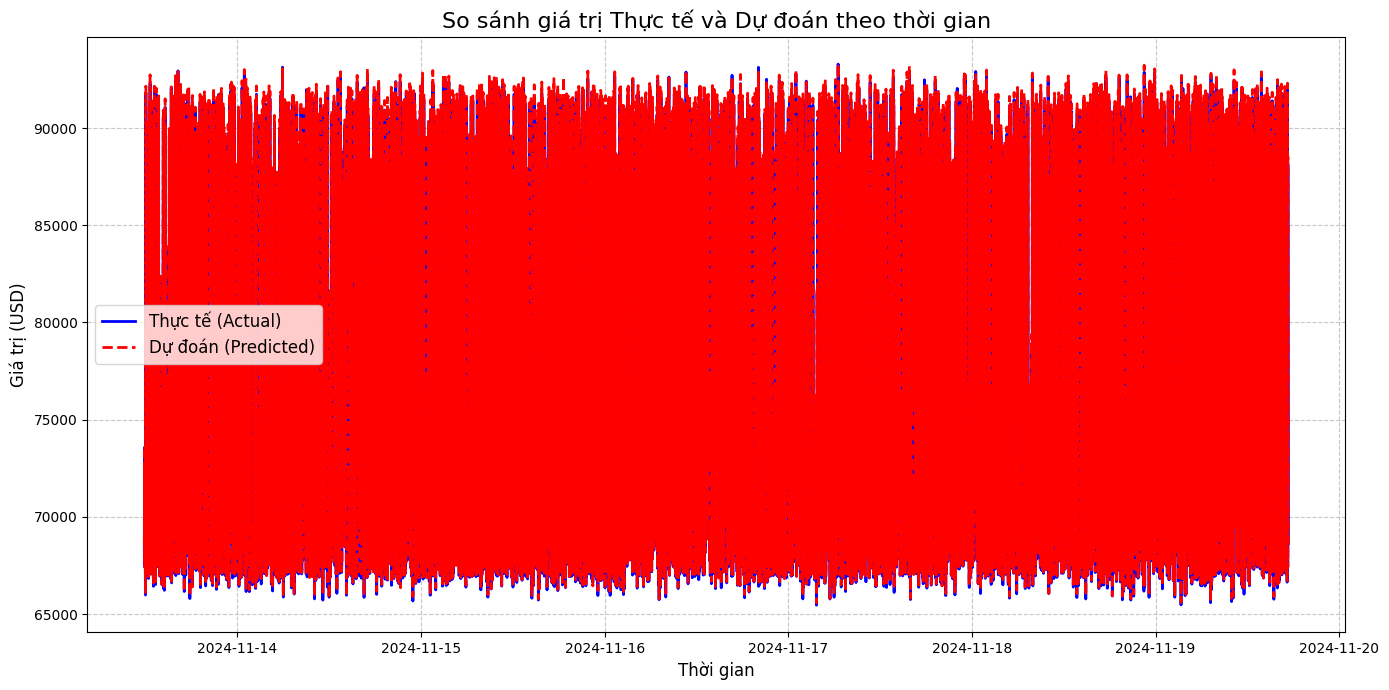

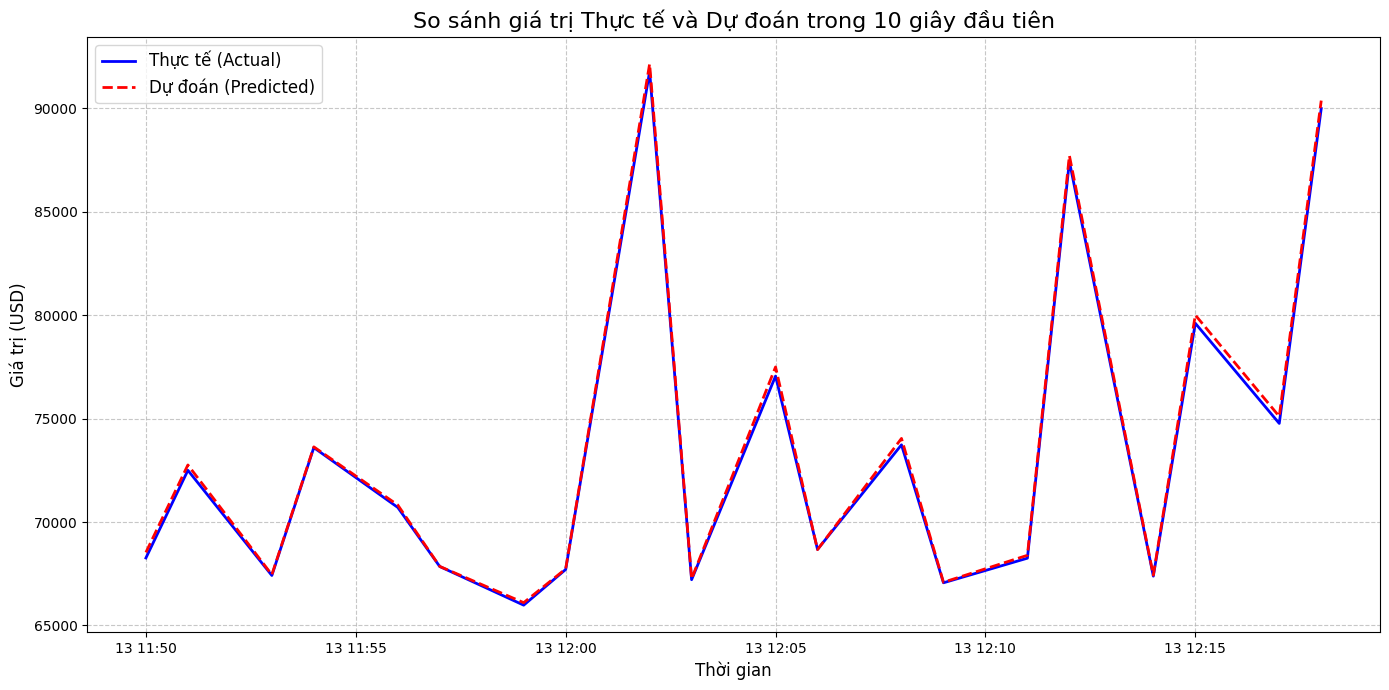

In [33]:
time_index_test = data.index[-len(y_test_original):]

results_df = pd.DataFrame({
    "Thời gian": time_index_test,
    "Thực tế (Actual)": y_test_original,
    "Dự đoán (Predicted)": y_pred_original,
    "Hiệu (Actual - Predicted)": y_test_original.flatten() - y_pred_original.flatten() 
})

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
print(results_df)

plt.figure(figsize=(14, 7))
plt.plot(results_df["Thời gian"], results_df["Thực tế (Actual)"], label="Thực tế (Actual)", color='blue', linestyle='-', linewidth=2)
plt.plot(results_df["Thời gian"], results_df["Dự đoán (Predicted)"], label="Dự đoán (Predicted)", color='red', linestyle='--', linewidth=2)
plt.title("So sánh giá trị Thực tế và Dự đoán theo thời gian", fontsize=16)
plt.xlabel("Thời gian", fontsize=12)
plt.ylabel("Giá trị (USD)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

results_df_10s = results_df.head(20)

plt.figure(figsize=(14, 7))
plt.plot(results_df_10s["Thời gian"], results_df_10s["Thực tế (Actual)"], label="Thực tế (Actual)", color='blue', linestyle='-', linewidth=2)
plt.plot(results_df_10s["Thời gian"], results_df_10s["Dự đoán (Predicted)"], label="Dự đoán (Predicted)", color='red', linestyle='--', linewidth=2)
plt.title("So sánh giá trị Thực tế và Dự đoán trong 10 giây đầu tiên", fontsize=16)
plt.xlabel("Thời gian", fontsize=12)
plt.ylabel("Giá trị (USD)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()